# Database manipulation with polars

You can use any database library to manipulate data in the ARIEL database. In this example we will be using polars.

In [ ]:
# Import the libraries
import polars as pl
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

## 1. How to get data about the experiment

As explained above, ARIEL stores every individual that existed during evolution in an SQL database. This includes individuals that died early as well as those that survived until the end. By querying this database, we can recreate population data and extract statistics about the evolutionary process.

### 1.1 Loading the database into a Polars DataFrame

All data about individuals is stored in the table individual.
Below is how to load this table into a Polars DataFrame.

In [5]:
# Load database table into Polars
conn = sqlite3.connect("__data__/database.db")

data = pl.DataFrame(
    conn.execute("SELECT * FROM individual").fetchall(),
    schema=[col[1] for col in conn.execute("PRAGMA table_info(individual)")]
)

data.head()


C:\Users\johng\AppData\Local\Temp\ipykernel_21012\3588941998.py:4: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  data = pl.DataFrame(


id,alive,time_of_birth,time_of_death,requires_eval,fitness_,requires_init,genotype_,tags_
i64,i64,i64,i64,i64,f64,i64,str,str
1,0,0,7,0,21.507857,0,"""[54.5476194721131, 18.78769761…","""{}"""
2,0,0,4,0,21.764198,0,"""[-23.51735411458668, 83.298954…","""{}"""
3,0,0,2,0,21.364822,0,"""[-41.8642899864318, -26.625290…","""{}"""
4,0,0,4,0,21.965413,0,"""[-2.399348473982663, 32.839368…","""{}"""
5,0,0,1,0,21.85274,0,"""[40.97966824037182, -45.669443…","""{}"""


### 1.2 Reconstructing the population per generation

ARIEL does not store a list of individuals per generation. Instead, each individual records:
- time_of_birth: the generation it was created
- time_of_death: the generation it disappeared

We reconstruct the population for every generation using this information.

In [6]:
# Determine generation range
min_gen = int(data["time_of_birth"].min())
max_gen = int(data["time_of_death"].max())

# Collect individuals alive per generation
population_per_gen = {
    gen: data.filter(
        (pl.col("time_of_birth") <= gen) & (pl.col("time_of_death") > gen) )["id"].to_list()
    for gen in range(min_gen, max_gen + 1)
    }

# Structure data as a Polars dataframe
pop_df = pl.DataFrame({
    "generation": list(population_per_gen.keys()),
    "individuals": list(population_per_gen.values()),
    "pop size": [len(v) for v in population_per_gen.values()]
    })

pop_df.head()

generation,individuals,pop size
i64,list[i64],i64
0,"[1, 2, … 100]",100
1,"[1, 2, … 156]",100
2,"[1, 2, … 202]",100
3,"[1, 2, … 250]",100
4,"[1, 9, … 300]",100


## 2. Computing fitness statistics per generation

Now that we know which individuals were alive in each generation, we can compute:
- Mean fitness
- Standard deviation
- Best (minimum) fitness

In [8]:
# Extract fitness values indexed by individual id
fitness_by_id = data.select(["id", "fitness_"])

means, stds, bests = [], [], []

for gen in pop_df["generation"]:
    ids = population_per_gen.get(gen, [])
    if not ids:
        means.append(np.nan)
        stds.append(np.nan)
        bests.append(np.nan)
        continue

    fits = (
        fitness_by_id
        .filter(pl.col("id").is_in(ids))
        .select(pl.col("fitness_").cast(pl.Float64))
        .to_series()
        .to_numpy()
    )

    if fits.size == 0:
        means.append(np.nan)
        stds.append(np.nan)
        bests.append(np.nan)
    else:
        means.append(float(np.mean(fits)))
        stds.append(float(np.std(fits)))
        bests.append(float(np.min(fits)))

# Add the statistics to the dataframe
pop_df = pop_df.with_columns([
    pl.Series("fitness_mean", means),
    pl.Series("fitness_std", stds),
    pl.Series("fitness_best", bests)
])

pop_df.head()


generation,individuals,pop size,fitness_mean,fitness_std,fitness_best
i64,list[i64],i64,f64,f64,f64
0,"[1, 2, … 100]",100,21.66666,0.273939,20.806873
1,"[1, 2, … 156]",100,21.399773,0.664911,19.846392
2,"[1, 2, … 202]",100,21.261569,0.748077,19.952315
3,"[1, 2, … 250]",100,21.159823,0.801033,19.862954
4,"[1, 9, … 300]",100,20.91889,0.847252,19.862954


## 3. Plotting the fitness progression

With the computed statistics, we can visualize how fitness changes over generations.

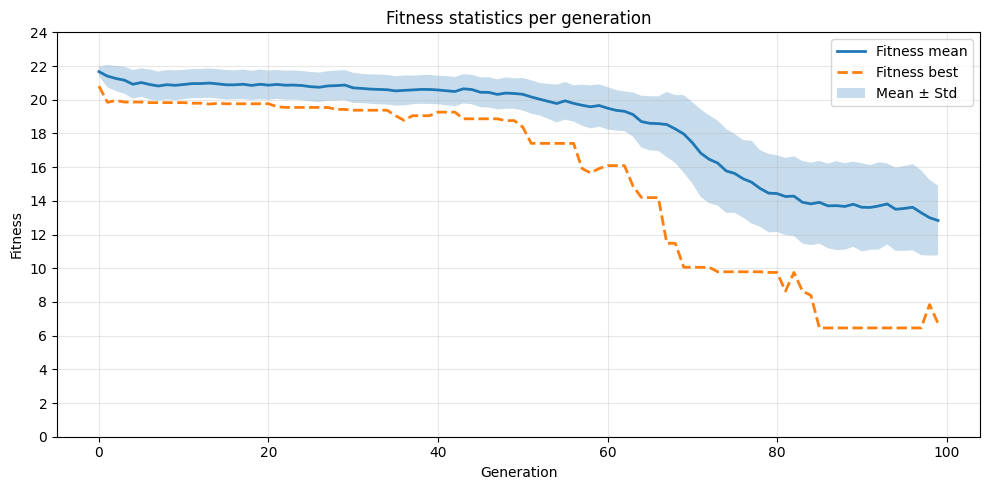

In [10]:
df = pop_df.drop_nulls(subset=["fitness_mean"])

x = df["generation"]
mean = df["fitness_mean"]
std = df["fitness_std"]
best = df["fitness_best"]

plt.figure(figsize=(10, 5))
plt.plot(x, mean, label="Fitness mean", linewidth=2)
plt.plot(x, best, "--", label="Fitness best", linewidth=2)
plt.fill_between(x, mean - std, mean + std, alpha=0.25, label="Mean ± Std")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness statistics per generation")
plt.legend()
plt.yticks(range(0, int(max(df["fitness_mean"]) + 5), 2))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
